In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import sqlite3
%matplotlib inline
from rubin_sim.utils import angular_separation, _ra_dec2_hpid
from rubin_sim.scheduler.model_observatory import KinemModel, ModelObservatory
from rubin_sim.scheduler.utils import SchemaConverter
import healpy as hp

In [2]:
con = sqlite3.connect('baseline_v3.3_10yrs.db')
data = pd.read_sql('select altitude,azimuth, fieldRA, fieldDec,observationStartMJD,rotTelPos, slewtime, observationId, night, filter, note, cummTelAz from observations ;', con)
con.close()

In [3]:
data

,altitude,azimuth,fieldRA,fieldDec,observationStartMJD,rotTelPos,slewTime,observationId,night,filter,note,cummTelAz
0,46.455870,132.523735,200.782211,-50.116498,60796.001439,43.832968,124.349157,0,0,r,"blob_long, gr, a",132.523735
1,44.067616,130.634167,205.280457,-48.985871,60796.001888,43.832968,4.791798,1,0,r,"blob_long, gr, a",130.557655
2,41.861627,132.897658,208.768832,-50.721324,60796.002335,43.832968,4.625595,2,0,r,"blob_long, gr, a",132.814350
3,39.621990,135.025151,212.491654,-52.367602,60796.002782,43.832968,4.635941,3,0,r,"blob_long, gr, a",134.937940
4,41.575825,128.790712,209.531249,-47.656241,60796.003233,43.832968,4.887546,4,0,r,"blob_long, gr, a",128.702991
...,...,...,...,...,...,...,...,...,...,...,...,...
2131084,26.989309,70.560506,359.507594,1.582229,64448.427471,-30.520044,4.900081,2131084,3652,z,greedy,186.528095
2131085,33.662765,76.389692,356.941992,-6.315225,64448.427933,-30.520044,5.868885,2131085,3652,z,greedy,192.463073
2131086,32.151996,73.287411,356.946173,-3.308834,64448.428377,-30.520044,4.373462,2131086,3652,z,greedy,189.467392
2131087,27.677993,75.882008,2.084889,-2.714454,64448.428832,-30.520044,5.316177,2131087,3652,z,greedy,192.167922


In [4]:
nd = data['night'][1:] - data['night'].values[0:-1]

same_filt = data['filter'].values[0:-1] == data['filter'].values[1:]

rtp_diff = data['rotTelPos'].values[1:] - data['rotTelPos'].values[0:-1]

In [5]:
same_filt

array([ True,  True,  True, ...,  True,  True,  True])

In [6]:
angs = angular_separation(data['azimuth'][1:].values,
                          data['altitude'][1:].values, 
                          data['azimuth'][0:-1].values, data['altitude'][0:-1].values)

In [7]:
angs

array([2.73341539, 2.75835966, 2.7591741 , ..., 3.01074229, 5.00689092,
       3.26354386])

In [8]:
# look for long slewtime, short distance
lssd = np.where((nd == 0) & (angs < 5.) & (same_filt == True) & (data['slewTime'].values[1:] > 20))[0]

In [9]:
lssd.size

1514

In [10]:
lssd

array([     29,      79,     499, ..., 2129712, 2130349, 2130904])

In [11]:
data.loc[28]

altitude                      30.679223
azimuth                      174.143864
fieldRA                      237.070084
fieldDec                     -84.934097
observationStartMJD        60796.014046
rotTelPos                     43.832968
slewTime                       5.677133
observationId                        28
night                                 0
filter                                r
note                   blob_long, gr, a
cummTelAz                    173.892283
Name: 28, dtype: object

In [12]:
data.loc[29]

altitude                      30.558929
azimuth                      180.082035
fieldRA                      140.983186
fieldDec                     -89.677611
observationStartMJD        60796.014808
rotTelPos                     43.832968
slewTime                      31.861423
observationId                        29
night                                 0
filter                                r
note                   blob_long, gr, a
cummTelAz                     179.82941
Name: 29, dtype: object

(array([  92.,   52.,   29.,   13.,   26.,   20.,    2.,    6.,    0.,
           5.,    2.,    4.,    0.,    0.,    0.,    2.,    2.,    4.,
          69., 1186.]),
 array([20.00430726, 21.77211961, 23.53993195, 25.30774429, 27.07555664,
        28.84336898, 30.61118133, 32.37899367, 34.14680602, 35.91461836,
        37.68243071, 39.45024305, 41.21805539, 42.98586774, 44.75368008,
        46.52149243, 48.28930477, 50.05711712, 51.82492946, 53.5927418 ,
        55.36055415]),
 <BarContainer object of 20 artists>)

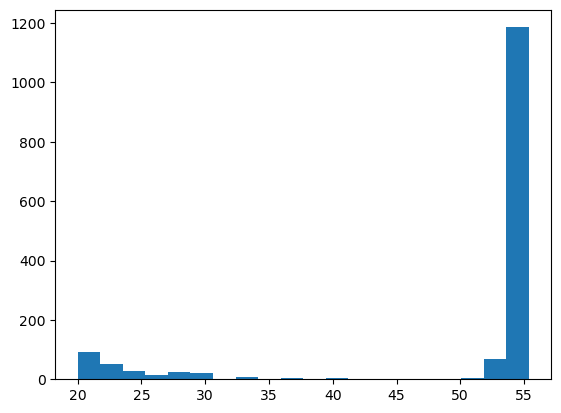

In [13]:
plt.hist(data['slewTime'][1:].values[lssd], bins=20)

Text(0.5, 1.0, 'sep < 5deg, same filter, same night, slewtime > 20')

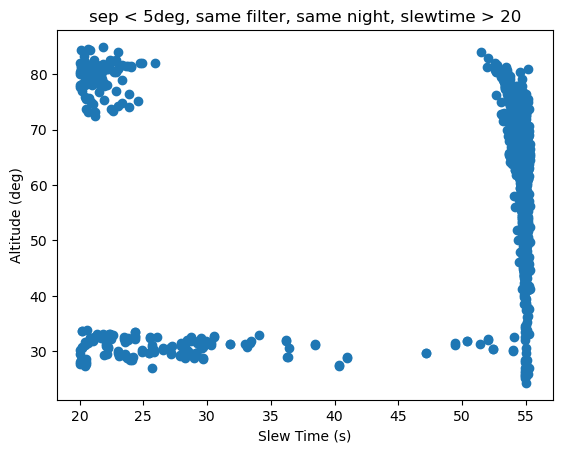

In [14]:
plt.scatter(data['slewTime'][1:].values[lssd], data['altitude'][1:].values[lssd])
plt.xlabel('Slew Time (s)')
plt.ylabel('Altitude (deg)')
plt.title('sep < 5deg, same filter, same night, slewtime > 20')

In [15]:
too_short = np.where((nd == 0) & (angs > 15.) & (same_filt == True) & (data['slewTime'].values[1:] < 5))[0]

In [16]:
too_short

array([], dtype=int64)

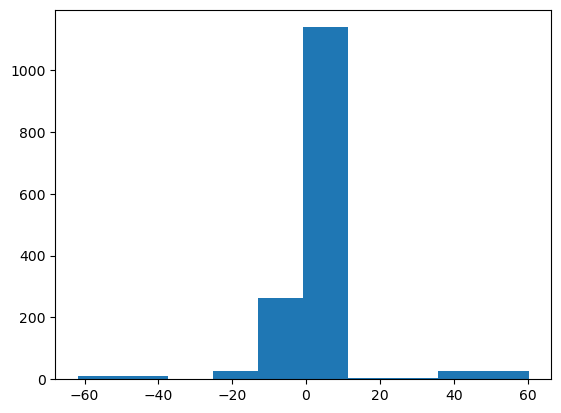

In [17]:
ack = plt.hist(rtp_diff[lssd])

In [18]:
# This is wrong, should use closest angle difference function thing, but mostly right.
dct = data['cummTelAz'].values[1:] - data['cummTelAz'].values[0:-1]

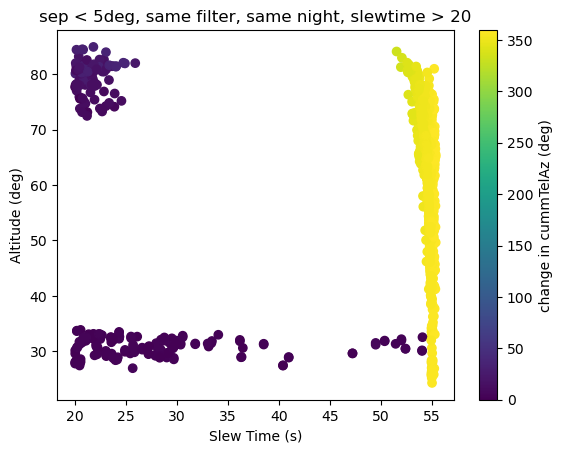

In [19]:
plt.scatter(data['slewTime'][1:].values[lssd], data['altitude'][1:].values[lssd], c=np.abs(dct[lssd]))
plt.xlabel('Slew Time (s)')
plt.ylabel('Altitude (deg)')
plt.title('sep < 5deg, same filter, same night, slewtime > 20')
cb = plt.colorbar()
cb.set_label('change in cummTelAz (deg)')

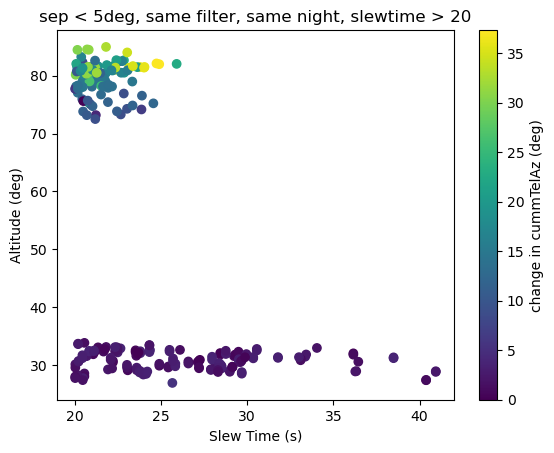

In [20]:
# look for long slewtime, short distance
lssd = np.where((nd == 0) & (angs < 5.) & (same_filt == True) & (data['slewTime'].values[1:] > 20)
               & (data['slewTime'].values[1:] < 45) )[0]
dct = data['cummTelAz'].values[1:] - data['cummTelAz'].values[0:-1]
plt.scatter(data['slewTime'][1:].values[lssd], data['altitude'][1:].values[lssd], c=np.abs(dct[lssd]))
plt.xlabel('Slew Time (s)')
plt.ylabel('Altitude (deg)')
plt.title('sep < 5deg, same filter, same night, slewtime > 20')
cb = plt.colorbar()
cb.set_label('change in cummTelAz (deg)')


In [21]:
lssd.size

251

In [22]:
np.unique(data['night']).size

2809

In [23]:
lssd = np.where((nd == 0) & (angs < 5.) &
                (same_filt == True) &
                (data['slewTime'].values[1:] > 20) & 
               (data['altitude'].values[1:] < 40) &
               (data['slewTime'].values[1:] < 50))[0]

In [24]:
lssd.size

151

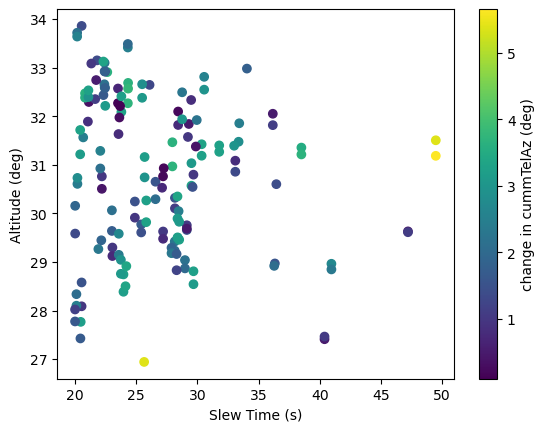

In [25]:
plt.scatter(data['slewTime'][1:].values[lssd], data['altitude'][1:].values[lssd], c=np.abs(dct[lssd]))
plt.xlabel('Slew Time (s)')
plt.ylabel('Altitude (deg)')

cb = plt.colorbar()
cb.set_label('change in cummTelAz (deg)')

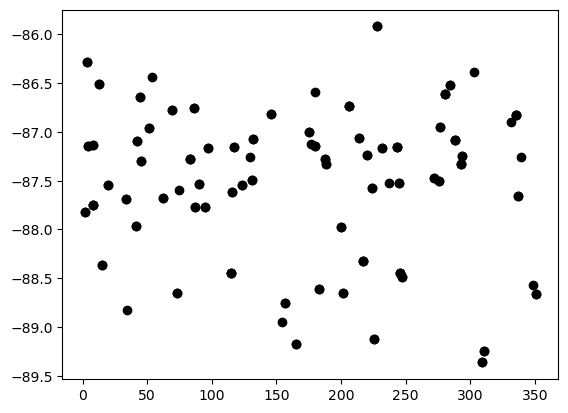

In [26]:
plt.plot(data['fieldRA'].values[1:][lssd],
        data['fieldDec'].values[1:][lssd], 'ko')

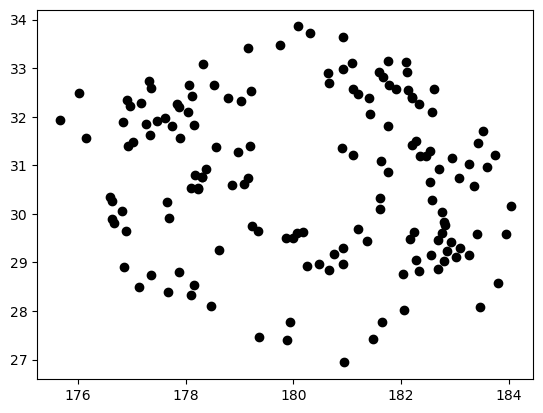

In [27]:
plt.plot(data['azimuth'].values[1:][lssd],
        data['altitude'].values[1:][lssd], 'ko')

In [28]:
lssd

array([     29,      79,     499,     897,    1761,    1811,    2931,
          2953,    3860,    3882,    6977,    7960,    7981,   16399,
         16449,   16858,   19134,   19184,   25225,   25247,   26394,
         26444,   26759,   50434,   50484,   51080,   51130,   80025,
         80075,   83106,   83156,   83282,  102257,  102307,  102433,
        146206,  146256,  146487,  206405,  206406,  206407,  206455,
        206456,  206457,  214675,  214725,  225551,  225601,  616504,
        659352,  659355,  659402,  659405,  783215,  783216,  783217,
        783490,  783491,  783492,  783540,  783541,  783542,  813007,
        826310,  827009,  827059,  827618,  827619,  827668,  827669,
        841367,  841417,  892369,  892419, 1019320, 1019328, 1019329,
       1019370, 1019378, 1019379, 1060007, 1060057, 1219103, 1219153,
       1226847, 1233875, 1233925, 1239950, 1239953, 1240000, 1240003,
       1246630, 1246680, 1247521, 1247522, 1247571, 1247572, 1258439,
       1258489, 1299

In [29]:
data.loc[783489]

altitude                    28.867845
azimuth                    175.110632
fieldRA                    141.100503
fieldDec                   -85.530143
observationStartMJD      62076.178375
rotTelPos                  -21.287358
slewTime                    15.324174
observationId                  783489
night                            1280
filter                              i
note                   pair_33, iz, a
cummTelAz                 -185.475419
Name: 783489, dtype: object

In [30]:
data.loc[783490]

altitude                    27.421005
azimuth                    177.827024
fieldRA                    180.070419
fieldDec                   -86.595043
observationStartMJD      62076.178933
rotTelPos                  -21.100604
slewTime                    14.238812
observationId                  783490
night                            1280
filter                              i
note                   pair_33, iz, a
cummTelAz                 -182.753046
Name: 783490, dtype: object

In [31]:
data.loc[783491]

altitude                    30.504117
azimuth                    178.223235
fieldRA                    114.725948
fieldDec                   -88.445284
observationStartMJD      62076.179583
rotTelPos                  -20.852654
slewTime                    22.199411
observationId                  783491
night                            1280
filter                              i
note                   pair_33, iz, a
cummTelAz                 -182.345598
Name: 783491, dtype: object

In [32]:
data.loc[783492]

altitude                    28.961564
azimuth                     180.91882
fieldRA                    247.166137
fieldDec                   -88.488765
observationStartMJD      62076.180451
rotTelPos                  -20.646414
slewTime                    40.945495
observationId                  783492
night                            1280
filter                              i
note                   pair_33, iz, a
cummTelAz                 -179.651207
Name: 783492, dtype: object

In [33]:
km = KinemModel()

In [34]:
i = 783490

slew_times = km.slew_times(np.array([np.radians(data['fieldRA'].values[i])]),
                          np.array([np.radians(data['fieldDec'].values[i])]),
                          data['observationStartMJD'].values[i],
                          rot_tel_pos=np.array([np.radians(data['rotTelPos'].values[i])]),
                          starting_alt_rad=np.array([np.radians(data['altitude'].values[i-1])]),
                          starting_az_rad=np.array([np.radians(data['azimuth'].values[i-1])]),
                          starting_rot_tel_pos_rad=np.array([np.radians(data['rotTelPos'].values[i-1])]),
                          lax_dome=True)

In [35]:
slew_times

array([4.28503013])

In [36]:
near_pole = np.where((data['azimuth'].values > 175) & (data['azimuth'].values < 185) & 
                     (data['fieldDec'].values < -85))[0]

In [37]:
near_pole.size

991

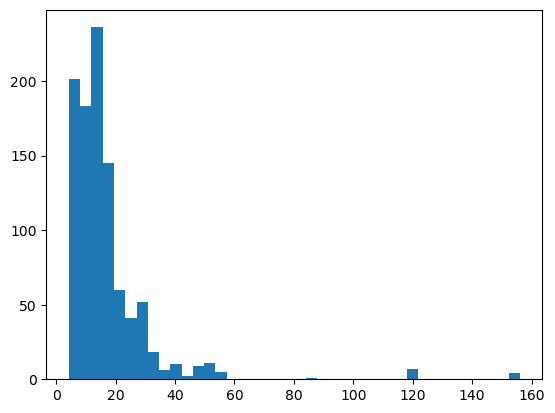

In [38]:
_ack = plt.hist(data['slewTime'].values[near_pole], bins=40)

In [39]:
data.loc[783489]

altitude                    28.867845
azimuth                    175.110632
fieldRA                    141.100503
fieldDec                   -85.530143
observationStartMJD      62076.178375
rotTelPos                  -21.287358
slewTime                    15.324174
observationId                  783489
night                            1280
filter                              i
note                   pair_33, iz, a
cummTelAz                 -185.475419
Name: 783489, dtype: object

In [40]:
sc = SchemaConverter()
obs = sc.opsim2obs('baseline_v3.3_10yrs.db')

In [41]:
obs = obs[np.where(obs['night'] == 1280)]

In [42]:
obs['mjd'][0]

62076.00180075104

In [43]:
mo = ModelObservatory()

In [44]:
mo.mjd = obs['mjd'][0] + mo.observatory.visit_time(obs[0]) / 3600.0 / 24.0
mo.obs_id_counter = obs["ID"][0] + 1
mo.observatory.parked = False
mo.observatory.current_ra_rad = obs["RA"][0]
mo.observatory.current_dec_rad = obs["dec"][0]
mo.observatory.current_rot_sky_pos_rad = obs["rotSkyPos"][0]
mo.observatory.cumulative_azimuth_rad = obs["cummTelAz"][0]
mo.observatory.current_filter = obs["filter"][0]
mo.observatory.mounted_filters = ['g', 'r', 'i', 'z', 'y']

In [45]:
mo.mjd

62076.00198593622

In [46]:
obs[389:397]['slewtime']

array([ 5.41899476,  6.59231891, 10.40306326, 15.32417408, 14.23881208,
       22.19941059, 40.945495  , 36.15913803])

In [47]:
new_obs, nn = mo.observe(obs[1:2])

/Users/yoachim/anaconda3/envs/rubin/lib/python3.11/site-packages/erfa/core.py:154: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warnings.warn('ERFA function "{}" yielded {}'.format(func_name, wmsg),


In [48]:
new_obs

array([(783098, 4.50337678, -0.48651078, 62076.00323478, 62076.02478292, 15., 'z', 3.94198026, 0., 1, 2.16466719, 0.47674312, 1.0570082, 0.92086074, 16.83106613, 1280, 107.90021185, 16., 1.11017324, 21.39880081, 0.48020926, 4.40084216, 1.94654503, 0.25, 0.43411796, -0.2227192, 'twilight_near_sun, 0', '', -1, 2, 1, 22.08161201, -0.39466002, 0., 0.94377525, 4.26816958, 3.77534463, -0.25125872, 0.35198801, 0.24794347, 2.17810515, 0.71454272, 91.3102419, -1.88234314, 0)],
      dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U40'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), ('sunAlt',

In [49]:
for i in np.arange(2,395):
    new_obs, nn = mo.observe(obs[i:i+1])

In [50]:
new_obs

array([(783491, 2.00234553, -1.54366142, 62076.18067023, 62076.21815322, 30., 'i', 1.04000371, 1.04686661, 2, 1.96944132, 0.82592985, 1.47050636, 1.26075623, 18.90186918, 1280, 22.2027359, 34., 0.05405403, 22.60759666, 0.53258059, 3.11061734, 4.87923413, 0.125, 0.74600045, -0.78779181, 'pair_33, iz, a', '', -1, 10, 1, 2.35172199, -0.36394747, -0.39466002, 5.9733072, 3.18094593, 3.77837427, -0.25225022, 0.37392163, 0.2627206, 1.83498087, 1.32416622, 91.90344624, -3.1910587, 0)],
      dtype=[('ID', '<i8'), ('RA', '<f8'), ('dec', '<f8'), ('mjd', '<f8'), ('flush_by_mjd', '<f8'), ('exptime', '<f8'), ('filter', '<U40'), ('rotSkyPos', '<f8'), ('rotSkyPos_desired', '<f8'), ('nexp', '<i8'), ('airmass', '<f8'), ('FWHM_500', '<f8'), ('FWHMeff', '<f8'), ('FWHM_geometric', '<f8'), ('skybrightness', '<f8'), ('night', '<i8'), ('slewtime', '<f8'), ('visittime', '<f8'), ('slewdist', '<f8'), ('fivesigmadepth', '<f8'), ('alt', '<f8'), ('az', '<f8'), ('pa', '<f8'), ('clouds', '<f8'), ('moonAlt', '<f8'), 

In [51]:
new_obs['slewtime']

array([22.2027359])

In [52]:
conditions = mo.return_conditions()

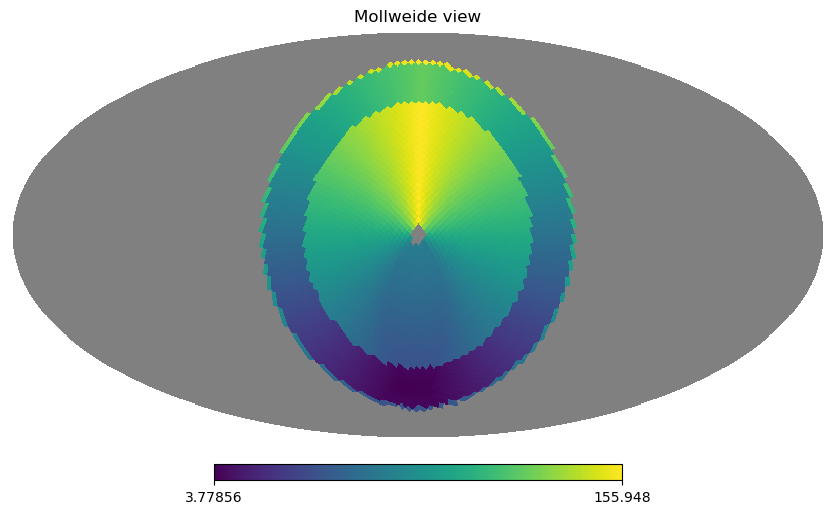

In [53]:
hp.mollview(conditions.slewtime, rot=((conditions.lmst.max()*180/12), conditions.site.latitude))

In [54]:
oo = obs[395]
mo.observatory.slew_times(oo['RA'], oo['dec'], mo.mjd, rot_tel_pos=oo['rotTelPos'],
                          starting_rot_tel_pos_rad=np.array([oo['rotTelPos']]),
                         filtername=oo['filter'])

array([4.33726469])

In [55]:
mo.observatory.slew_times(oo['RA'], oo['dec'], mo.mjd, rot_tel_pos=oo['rotTelPos'],
                         filtername=oo['filter'])

array([40.94717534])

In [56]:
hpid = _ra_dec2_hpid(conditions.nside, oo['RA'], oo['dec'])

In [57]:
conditions.slewtime[hpid]

4.401373682556542

In [58]:
oo['rotTelPos']

-0.36034789641974996

In [59]:
mo.observatory.current_rot_sky_pos_rad

array([1.04000371])

In [60]:
new_obs['rotTelPos']

array([-0.36394747])

In [61]:
np.degrees(obs['rotTelPos'][390:397])

array([-21.62865679, -21.43266195, -21.28735809, -21.10060372,
       -20.85265397, -20.64641362, -20.26388456])

In [62]:
mo.observatory.current_rot_sky_pos_rad

array([1.04000371])

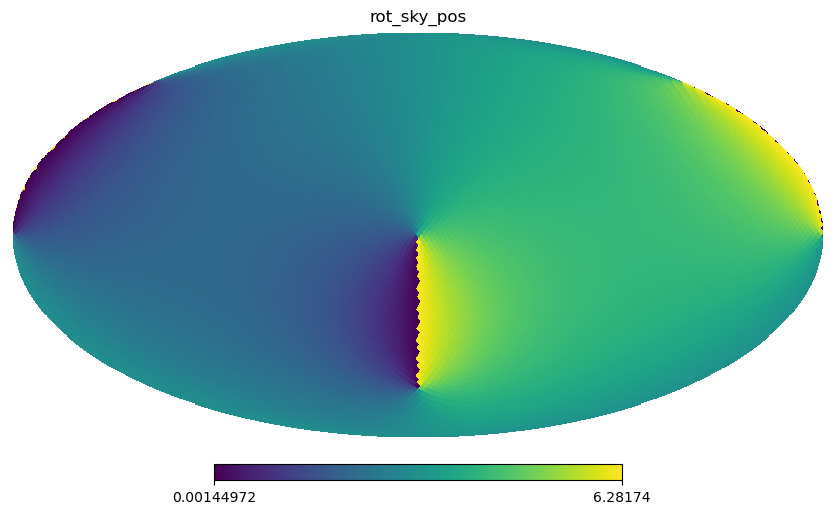

In [63]:
rot_tel_pos = 0.
rot_sky_pos = (rot_tel_pos - conditions.pa) % (2.*np.pi)
hp.mollview(rot_sky_pos, rot=((conditions.lmst.max()*180/12), conditions.site.latitude), title='rot_sky_pos')

In [65]:
# looks like there's a discontinuity, so if we track through that assuming rot_sky_pos stays constant, then 
# the rot_tel_pos will look wrong, or something. Can I solve this with just having rot_sky_pos between -pi and pi?

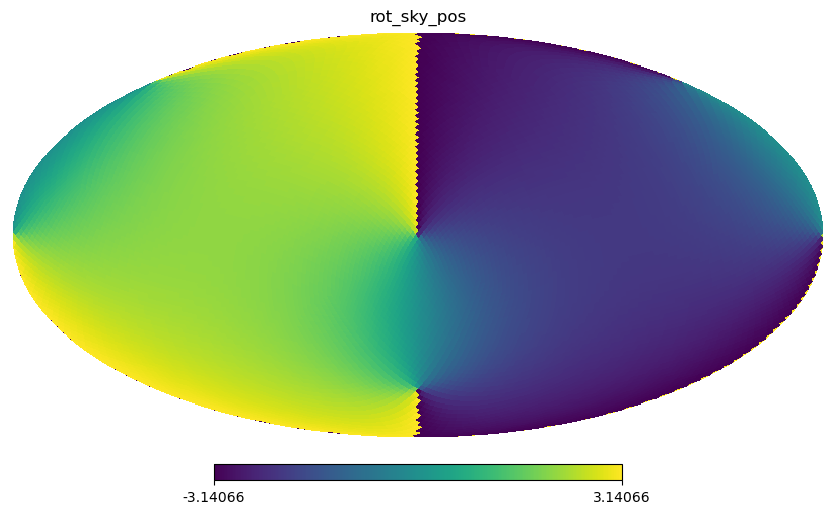

In [66]:
rot_sky_pos[np.where(rot_sky_pos > np.pi)] -= 2.*np.pi
hp.mollview(rot_sky_pos, rot=((conditions.lmst.max()*180/12), conditions.site.latitude), title='rot_sky_pos')